In [1]:
#PROJET 4 - NETTOYAGE ET TRAITEMENT DONNEES

import numpy as np
import pandas as pd
import scipy.stats as st
%matplotlib inline
import matplotlib.pyplot as plt
import datetime as dt
import statsmodels.api as sm
import seaborn as sns
import re
import math
pd.set_option('display.max_rows', 150)

In [2]:
#FONCTIONS
def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT

# NETTOYAGE DES DONNEES

In [3]:
#import données

customers = pd.read_csv('dataset_P4/customers.csv')
products = pd.read_csv('dataset_P4/products.csv')
transactions = pd.read_csv('dataset_P4/transactions.csv')
transactions_0 = transactions.copy() #on garde une copie de l'original avant de le modifier

In [4]:
#on verifie si il y a des valeurs manquantes
print(transactions.index[transactions.isnull().any(axis=1)])
print(products.index[products.isnull().any(axis=1)])
print(customers.index[customers.isnull().any(axis=1)])

Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')


In [5]:
#on verifie si il y a des doublons
print('products : ', products.drop_duplicates(subset = 'id_prod').shape, products.shape)
print('customers : ', customers.drop_duplicates(subset = 'client_id').shape, customers.shape)
print('transactions : ', transactions.drop_duplicates(subset = ['session_id', 'client_id', 'id_prod']).shape, transactions.shape)

products :  (3287, 3) (3287, 3)
customers :  (8623, 3) (8623, 3)
transactions :  (336409, 4) (337016, 4)


In [6]:
#on repère les doublons dans le df transactions
doublons = transactions.duplicated(subset = ['session_id', 'client_id', 'id_prod'])
doublons[doublons == True]

2365      True
2895      True
7283      True
13745     True
20470     True
          ... 
335947    True
335953    True
336119    True
336268    True
336336    True
Length: 607, dtype: bool

In [7]:
#lignes tests
transactions[transactions.id_prod == 'T_0']

,id_prod,date,session_id,client_id
1431,T_0,test_2021-03-01 02:30:02.237420,s_0,ct_1
2365,T_0,test_2021-03-01 02:30:02.237446,s_0,ct_1
2895,T_0,test_2021-03-01 02:30:02.237414,s_0,ct_1
5955,T_0,test_2021-03-01 02:30:02.237441,s_0,ct_0
7283,T_0,test_2021-03-01 02:30:02.237434,s_0,ct_1
...,...,...,...,...
332594,T_0,test_2021-03-01 02:30:02.237445,s_0,ct_0
332705,T_0,test_2021-03-01 02:30:02.237423,s_0,ct_1
332730,T_0,test_2021-03-01 02:30:02.237421,s_0,ct_1
333442,T_0,test_2021-03-01 02:30:02.237431,s_0,ct_1


In [8]:
# on supprime les lignes 'test' de transactions
transactions = transactions[transactions.id_prod != 'T_0']

In [9]:
doublons2 = transactions[transactions.duplicated(subset = ['session_id', 'client_id', 'id_prod'], keep=False)]
doublons2.sort_values(by = ['session_id','client_id'])

,id_prod,date,session_id,client_id
47416,0_1403,2021-10-05 06:41:12.627312,s_100238,c_7849
223462,0_1403,2021-10-05 06:44:23.963598,s_100238,c_7849
74234,0_1360,2021-10-05 13:33:28.245483,s_100388,c_7883
318544,0_1360,2021-10-05 13:56:17.131590,s_100388,c_7883
50547,0_1172,2021-10-05 21:49:22.798997,s_100555,c_2786
...,...,...,...,...
172131,2_112,2021-10-01 21:31:02.225913,s_98602,c_4683
306162,0_2264,2021-10-02 07:34:12.879481,s_98821,c_7601
318147,0_2264,2021-10-02 07:56:53.475360,s_98821,c_7601
12366,0_2061,2021-10-02 18:00:22.785281,s_99024,c_6407


In [10]:
# on constate qu'il y a certaines transactions en double à quelques minutes d'intervalles.
#on choisit de supprimer ces transactions
#transactions.sort_values(by = ['session_id','client_id'], inplace = True)
#transactions.drop_duplicates(subset = ['session_id', 'client_id', 'id_prod'], inplace = True)

#EDIT : ON CONSIDERE CES TRANSACTIONS COMME DES ACHATS SIMULTANEES D'UN MEME PRODUIT, ON CONSERVE DONC FINALEMENT CES LIGNES

In [11]:
# On verifie si il y a des valeurs incohérentes via la fonction describe()

#products
products.describe(include = 'all')

,id_prod,price,categ
count,3287,3287.000000,3287.000000
unique,3287,NaN,NaN
top,2_111,NaN,NaN
freq,1,NaN,NaN
mean,NaN,21.856641,0.370246
std,NaN,29.847908,0.615387
min,NaN,-1.000000,0.000000
25%,NaN,6.990000,0.000000
50%,NaN,13.060000,0.000000
75%,NaN,22.990000,1.000000


In [12]:
#on supprime le produit test (index 731)
products.drop([731], inplace = True)

# customers
customers.describe(include = 'all')

,client_id,sex,birth
count,8623,8623,8623.000000
unique,8623,2,NaN
top,c_1427,f,NaN
freq,1,4491,NaN
mean,NaN,NaN,1978.280877
std,NaN,NaN,16.919535
min,NaN,NaN,1929.000000
25%,NaN,NaN,1966.000000
50%,NaN,NaN,1979.000000
75%,NaN,NaN,1992.000000


In [13]:
#transactions
transactions.describe(include = 'all')

,id_prod,date,session_id,client_id
count,336816,336816,336816,336816
unique,3265,336816,169194,8600
top,1_369,2021-05-12 05:26:03.683263,s_118668,c_1609
freq,1081,1,14,12855


In [14]:
# traitement date transactions : à partir de la colonne 'date',
# on crée les colonnes : 'date_transaction', année', 'mois','jour','jour_semaine','weekend', 'hour', 'time'

#ajout des colonnes dates et heure
transactions['date_transaction'] = [x[0:19] for x in transactions['date']] 
transactions['date_transaction'] = pd.to_datetime(transactions['date_transaction'], errors = 'coerce')
transactions["year"] = transactions['date_transaction'].map(lambda d: d.year)
transactions["month"] = transactions['date_transaction'].map(lambda d: d.month)
transactions["week"] = transactions['date_transaction'].map(lambda d: d.week)
transactions["day"] = transactions['date_transaction'].map(lambda d: d.day)
transactions["week_day"] = transactions['date_transaction'].map(lambda d: d.day_name())
transactions["weekend"] = transactions["week_day"].isin(['Saturday', 'Sunday'])
transactions['hour'] = transactions['date_transaction'].map(lambda d: d.hour)
transactions['time'] = transactions['date_transaction'].map(lambda d: d.time())
transactions['date_transaction'] = transactions['date_transaction'].map(lambda d: d.date())

transactions.head()

,id_prod,date,session_id,client_id,date_transaction,year,month,week,day,week_day,weekend,hour,time
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,2021-04-10,2021,4,14,10,Saturday,True,18,18:37:28
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277,2022-02-03,2022,2,5,3,Thursday,False,1,01:55:53
2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270,2021-09-23,2021,9,38,23,Thursday,False,15,15:13:46
3,0_2186,2021-10-17 03:27:18.783634,s_105936,c_4597,2021-10-17,2021,10,41,17,Sunday,True,3,03:27:18
4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242,2021-07-17,2021,7,28,17,Saturday,True,20,20:34:25


In [15]:
#ajout de 'timeslot'

timeslots = ['night', 'morning','afternoon', 'evening']
hourslots = [0, 6, 12, 18, 24]
transactions['timeslot'] = pd.cut(transactions['hour'], bins=hourslots, labels=timeslots, right = False)
transactions.head()

,id_prod,date,session_id,client_id,date_transaction,year,month,week,day,week_day,weekend,hour,time,timeslot
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,2021-04-10,2021,4,14,10,Saturday,True,18,18:37:28,evening
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277,2022-02-03,2022,2,5,3,Thursday,False,1,01:55:53,night
2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270,2021-09-23,2021,9,38,23,Thursday,False,15,15:13:46,afternoon
3,0_2186,2021-10-17 03:27:18.783634,s_105936,c_4597,2021-10-17,2021,10,41,17,Sunday,True,3,03:27:18,night
4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242,2021-07-17,2021,7,28,17,Saturday,True,20,20:34:25,evening


In [16]:
#on rajoute une colonne 'n_session'
transactions['session_number'] = pd.to_numeric([x[2:] for x in transactions['session_id']])

#on trie le df transaction
transactions.sort_values(by = ['session_number', 'client_id', 'date_transaction','time'], inplace = True)

In [17]:
#on crée un df 'data' qui rassemble toutes les informations pour chaque transaction
data = transactions[['session_id', 'date_transaction', 'time',  'year', 'month', 'week', 'day', 'week_day',\
                    'weekend', 'hour', 'timeslot', 'client_id', 'id_prod']].copy()

#on rajoute les informations produits
data = data.merge(products, on = 'id_prod', how = 'left') #jointure externe à gauche
data.head()

,session_id,date_transaction,time,year,month,week,day,week_day,weekend,hour,timeslot,client_id,id_prod,price,categ
0,s_1,2021-03-01,00:01:07,2021,3,9,1,Monday,False,0,night,c_329,0_1259,11.99,0.0
1,s_2,2021-03-01,00:02:26,2021,3,9,1,Monday,False,0,night,c_664,0_1390,19.37,0.0
2,s_3,2021-03-01,00:02:38,2021,3,9,1,Monday,False,0,night,c_580,0_1352,4.50,0.0
3,s_3,2021-03-01,00:09:29,2021,3,9,1,Monday,False,0,night,c_580,0_2245,NaN,NaN
4,s_3,2021-03-01,00:10:37,2021,3,9,1,Monday,False,0,night,c_580,0_1638,5.46,0.0


In [18]:
# on verifie si il y a des valeurs de prix/categories manquantes pour certains produits achetés
list_nan = data.index[data.isnull().any(axis=1)] #liste des index comportant des Nan
print(list_nan)

Int64Index([     3,   1562,   6371,  21047,  25322,  25781,  25967,  26062,
             27638,  30077,
            ...
            315445, 318036, 322615, 323566, 327380, 327445, 331688, 332579,
            332846, 336566],
           dtype='int64', length=103)


In [19]:
#lignes du df data présentes dans la liste list_nan
data[data.index.isin(list_nan)]

,session_id,date_transaction,time,year,month,week,day,week_day,weekend,hour,timeslot,client_id,id_prod,price,categ
3,s_3,2021-03-01,00:09:29,2021,3,9,1,Monday,False,0,night,c_580,0_2245,NaN,NaN
1562,s_783,2021-03-02,15:55:49,2021,3,9,2,Tuesday,False,15,afternoon,c_8060,0_2245,NaN,NaN
6371,s_3159,2021-03-07,20:00:01,2021,3,9,7,Sunday,True,20,evening,c_1189,0_2245,NaN,NaN
21047,s_10427,2021-03-23,15:57:44,2021,3,12,23,Tuesday,False,15,afternoon,c_5869,0_2245,NaN,NaN
25322,s_12567,2021-03-28,10:46:04,2021,3,12,28,Sunday,True,10,morning,c_966,0_2245,NaN,NaN
25781,s_12792,2021-03-28,21:39:14,2021,3,12,28,Sunday,True,21,evening,c_2688,0_2245,NaN,NaN
25967,s_12886,2021-03-29,02:10:32,2021,3,13,29,Monday,False,2,night,c_1025,0_2245,NaN,NaN
26062,s_12938,2021-03-29,04:29:29,2021,3,13,29,Monday,False,4,night,c_1025,0_2245,NaN,NaN
27638,s_13738,2021-03-30,23:29:02,2021,3,13,30,Tuesday,False,23,evening,c_7790,0_2245,NaN,NaN
30077,s_14980,2021-04-02,14:31:03,2021,4,13,2,Friday,False,14,afternoon,c_7849,0_2245,NaN,NaN


In [20]:
#liste des produits n'ayant pas d'info
print('livres avec données manquantes : ',pd.unique(data[data.index.isin(list_nan)]['id_prod']).tolist())
#nombre de livres uniques vendus
print('nbre de livres uniques vendus : ', data['id_prod'].nunique())
#exemplaires vendus du livre en question
print('exemplaires vendus du livre 0_2245 : ', len(data[data['id_prod'] == '0_2245']))

livres avec données manquantes :  ['0_2245']
nbre de livres uniques vendus :  3265
exemplaires vendus du livre 0_2245 :  103


In [21]:
#on décide de supprimer les transactions pour le produit '0_2245' du df data
data = data[~data.index.isin(list_nan)]

#on crée une colonne age(en se basant sur 2022)
customers['age'] = 2022 - customers['birth']

#on crée une colonne age_range
age_bins = [0, 30, 50, 120]
customers['age_range'] = pd.cut(customers['age'], bins=age_bins,
                                labels = ['moins de 30 ans', '30-50 ans', 'plus de 50 ans'],
                                          include_lowest = False)

#on rajoute les informations clients
list_columns = ['session_id', 'date_transaction', 'time',  'year', 'month', 'week', 'day', 'week_day',\
                    'weekend', 'hour', 'timeslot', 'id_prod', 'price', 'categ', 'client_id']
data = data[list_columns] #rearrangement colonnes
data = data.merge(customers, on = 'client_id', how = 'left') #jointure externe à gauche

#on ajoute une colonne 'age_purchase'
data['age_purchase'] = data['year'] - data['birth']
del data['birth']
data.head()

,session_id,date_transaction,time,year,month,week,day,week_day,weekend,hour,timeslot,id_prod,price,categ,client_id,sex,age,age_range,age_purchase
0,s_1,2021-03-01,00:01:07,2021,3,9,1,Monday,False,0,night,0_1259,11.99,0.0,c_329,f,55,plus de 50 ans,54
1,s_2,2021-03-01,00:02:26,2021,3,9,1,Monday,False,0,night,0_1390,19.37,0.0,c_664,m,62,plus de 50 ans,61
2,s_3,2021-03-01,00:02:38,2021,3,9,1,Monday,False,0,night,0_1352,4.50,0.0,c_580,m,34,30-50 ans,33
3,s_3,2021-03-01,00:10:37,2021,3,9,1,Monday,False,0,night,0_1638,5.46,0.0,c_580,m,34,30-50 ans,33
4,s_3,2021-03-01,00:38:57,2021,3,9,1,Monday,False,0,night,0_1110,4.71,0.0,c_580,m,34,30-50 ans,33


In [22]:
#on rajoute une colonne price_range, sachant que les quantiles de prix sont q(0.33) = 10.3 et q(0.67) =  17.14
price_bins = [0,10,17,300]
price_labels = ['low', 'medium', 'high']
data['price_range'] = pd.cut(data['price'], bins=price_bins, labels = price_labels, right = True)

list_columns = ['session_id', 'date_transaction', 'time',  'year', 'month', 'week', 'day', 'week_day',\
                    'weekend', 'hour', 'timeslot', 'id_prod', 'price', 'price_range', 'categ', 'client_id', 'sex', 'age', 'age_purchase', 'age_range']
data = data[list_columns] #rearrangement colonnes

data.head()

,session_id,date_transaction,time,year,month,week,day,week_day,weekend,hour,timeslot,id_prod,price,price_range,categ,client_id,sex,age,age_purchase,age_range
0,s_1,2021-03-01,00:01:07,2021,3,9,1,Monday,False,0,night,0_1259,11.99,medium,0.0,c_329,f,55,54,plus de 50 ans
1,s_2,2021-03-01,00:02:26,2021,3,9,1,Monday,False,0,night,0_1390,19.37,high,0.0,c_664,m,62,61,plus de 50 ans
2,s_3,2021-03-01,00:02:38,2021,3,9,1,Monday,False,0,night,0_1352,4.50,low,0.0,c_580,m,34,33,30-50 ans
3,s_3,2021-03-01,00:10:37,2021,3,9,1,Monday,False,0,night,0_1638,5.46,low,0.0,c_580,m,34,33,30-50 ans
4,s_3,2021-03-01,00:38:57,2021,3,9,1,Monday,False,0,night,0_1110,4.71,low,0.0,c_580,m,34,33,30-50 ans


In [23]:
# on verifie si il y a des valeurs manquantes suite à l'ajout des données clients
list_nan_2 = data.index[data.isnull().any(axis=1)] #liste des index comportant des Nan
print(list_nan_2)

Int64Index([], dtype='int64')


In [24]:
# On ajoute la colonne 'cum_sales'
data['cum_sales'] = data['price'].cumsum()
data.head(10)

,session_id,date_transaction,time,year,month,week,day,week_day,weekend,hour,...,id_prod,price,price_range,categ,client_id,sex,age,age_purchase,age_range,cum_sales
0,s_1,2021-03-01,00:01:07,2021,3,9,1,Monday,False,0,...,0_1259,11.99,medium,0.0,c_329,f,55,54,plus de 50 ans,11.99
1,s_2,2021-03-01,00:02:26,2021,3,9,1,Monday,False,0,...,0_1390,19.37,high,0.0,c_664,m,62,61,plus de 50 ans,31.36
2,s_3,2021-03-01,00:02:38,2021,3,9,1,Monday,False,0,...,0_1352,4.50,low,0.0,c_580,m,34,33,30-50 ans,35.86
3,s_3,2021-03-01,00:10:37,2021,3,9,1,Monday,False,0,...,0_1638,5.46,low,0.0,c_580,m,34,33,30-50 ans,41.32
4,s_3,2021-03-01,00:38:57,2021,3,9,1,Monday,False,0,...,0_1110,4.71,low,0.0,c_580,m,34,33,30-50 ans,46.03
5,s_4,2021-03-01,00:04:54,2021,3,9,1,Monday,False,0,...,0_1458,6.55,low,0.0,c_7912,f,33,32,30-50 ans,52.58
6,s_4,2021-03-01,00:17:11,2021,3,9,1,Monday,False,0,...,1_310,14.20,medium,1.0,c_7912,f,33,32,30-50 ans,66.78
7,s_5,2021-03-01,00:05:18,2021,3,9,1,Monday,False,0,...,0_1358,16.49,medium,0.0,c_2033,f,66,65,plus de 50 ans,83.27
8,s_6,2021-03-01,00:05:44,2021,3,9,1,Monday,False,0,...,0_1073,13.99,medium,0.0,c_4908,f,41,40,30-50 ans,97.26
9,s_6,2021-03-01,00:07:48,2021,3,9,1,Monday,False,0,...,0_279,16.99,medium,0.0,c_4908,f,41,40,30-50 ans,114.25


In [25]:
#ajout d'une colonne tranche d'âge séparée en '- de 50 ans' et 'plus de 50 ans'

#on crée une colonne age_range_2
age_bins_2 = [0, 50, 120]
data['age_range_2'] = pd.cut(data['age'], bins=age_bins_2,
                                labels = ['moins de 50 ans', 'plus de 50 ans'],
                                          include_lowest = False)

In [27]:
customers[customers['client_id'].isin(['c_1609', 'c_4958','c_6714','c_3454'])]

,client_id,sex,birth,age,age_range
1378,c_4958,m,1999,23,moins de 30 ans
1911,c_6714,f,1968,54,plus de 50 ans
3642,c_1609,m,1980,42,30-50 ans
8088,c_3454,m,1969,53,plus de 50 ans


# ANALYSE DES VENTES

nombre clients uniques :  8623
age moyen des clients :  43.7 ans
age median des clients :  43.0 ans


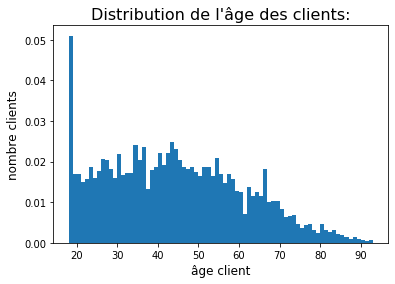

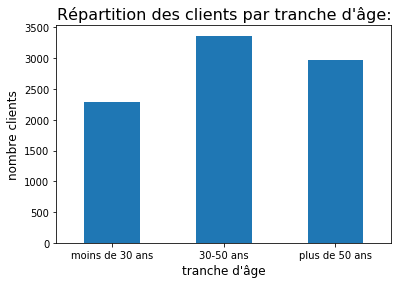

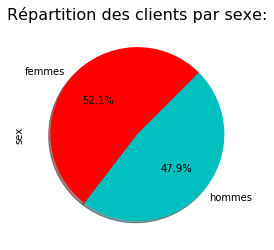

In [642]:
#PROFILAGE CLIENTS

#NBRE CLIENTS
n_clients = len(customers)
print('nombre clients uniques : ', n_clients)

# AGE
age_mean = customers['age'].mean() #moyenne
print('age moyen des clients : ', round(age_mean,1),'ans')

age_med = np.median(customers['age']) #mediane
print('age median des clients : ', round(age_med,1),'ans')

plt.figsize=(10, 5)
customers["age"].hist(density = True,bins=75)
plt.grid(b=None)
plt.title('Distribution de l\'âge des clients:', size = 16)
plt.xlabel('âge client', size = 12)
plt.ylabel('nombre clients', size = 12)
plt.savefig('P4_02_graphiques/hist_repartition_clients_age.png')
plt.show()

plt.figsize=(10, 5)
customers.groupby('age_range').size().plot(kind='bar')
plt.title('Répartition des clients par tranche d\'âge:', size = 16)
plt.xlabel('tranche d\'âge', size = 12)
plt.xticks(rotation = 'horizontal')
plt.ylabel('nombre clients', size = 12)
plt.savefig('P4_02_graphiques/hist_repartition_clients_trancheage.png')
plt.show()

#SEXE
customers["sex"].value_counts(normalize=True).plot(kind='pie', labels = ['femmes','hommes'], autopct='%1.1f%%', shadow=True, startangle=45, colors = ['r','c'])
plt.title('Répartition des clients par sexe:', size = 16)
plt.savefig('P4_02_graphiques/pie_repartition_sexe.png')
plt.show()

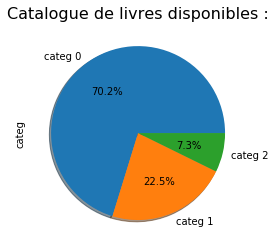

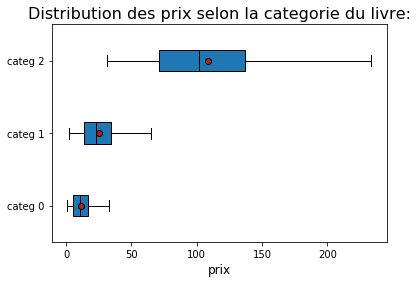

--------------------
Prix moyen categ 0:
 11.73 euros.
Ecart-type :
 7.57 

Prix moyen categ 1:
 25.53 euros.
Ecart-type :
 15.43 

Prix moyen categ 2:
 108.35 euros.
Ecart-type :
 49.56 



In [643]:
#Analyse du catalogue de livres à la vente

#distribution catégories parmi les livres DISPONIBLES
products["categ"].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%',
                                                    shadow=True, labels = ['categ 0','categ 1', 'categ 2'])
plt.title('Catalogue de livres disponibles :', size = 16)
plt.savefig('P4_02_graphiques/pie_catalogue_livres_categ.png')
plt.show()

#boxplot prix des livres par categorie
categs = [0,1,2]
groupes_livres = []
for c in categs:
    groupes_livres.append(products[products['categ']== c]['price'])
medianprops = {'color':"black"} 
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}

plt.boxplot(groupes_livres, labels=['categ 0','categ 1', 'categ 2'], showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)

plt.title('Distribution des prix selon la categorie du livre:', size = 16)
plt.xlabel('prix', size = 12)
plt.savefig('P4_02_graphiques/boxplot_prix_vs_categ.png')
plt.show()

#moyenne et écart-type par categ de livres
print('-'*20)
print('Prix moyen categ 0:\n', round(groupes_livres[0].mean(),2),'euros.\nEcart-type :\n', round(groupes_livres[0].std(),2),'\n')
print('Prix moyen categ 1:\n', round(groupes_livres[1].mean(),2),'euros.\nEcart-type :\n', round(groupes_livres[1].std(),2),'\n')
print('Prix moyen categ 2:\n', round(groupes_livres[2].mean(),2),'euros.\nEcart-type :\n', round(groupes_livres[2].std(),2),'\n')

Ventes totales sur la période: 5796577.77 euros. 
 --------------------


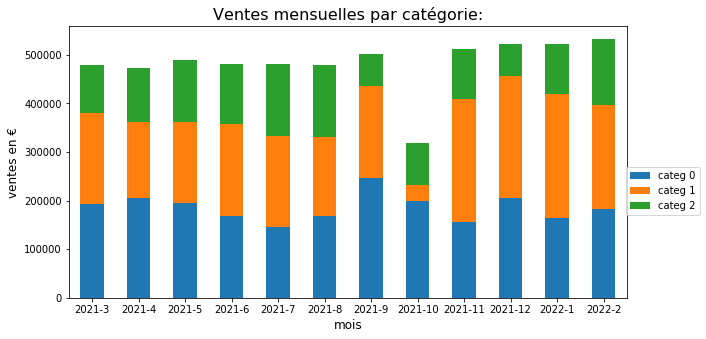

In [644]:
# ANALYSE VENTES

#CA TOTAL
print('Ventes totales sur la période:', round(data['cum_sales'].max(),2), 'euros. \n','-'*20)

#ventes mensuelles
data_month = data.groupby(['year','month']).sum().copy()
data_month['sales'] = data_month['price']
data_month = data_month[['sales']]
data_month.reset_index(inplace = True)
data_month['date'] = data_month.year.astype(str) + '-' + data_month.month.astype(str)

#ajout ventes mensuelles par categories
for c in categs:
    data_month_categ = data[data['categ'] == c].groupby(['year','month']).sum()
    data_month_categ.reset_index(inplace = True)
    data_month['categ '+ str(c)] = data_month_categ['price']

#affichage stacked bar    
data_month[['categ 0','categ 1','categ 2']].plot(kind='bar', stacked=True, figsize=(10, 5))
labels = data_month['date'].values
plt.xticks(range(0,len(data_month['date'])), labels, rotation='horizontal')
plt.xlabel('mois', size = 12)
plt.ylabel('ventes en €', size = 12)
plt.legend(loc='upper left', frameon=True, bbox_to_anchor=(0.99, 0.5))
plt.title('Ventes mensuelles par catégorie:', size = 16)
plt.savefig('P4_02_graphiques/hist_ventes_mensuelles.png')
plt.show()

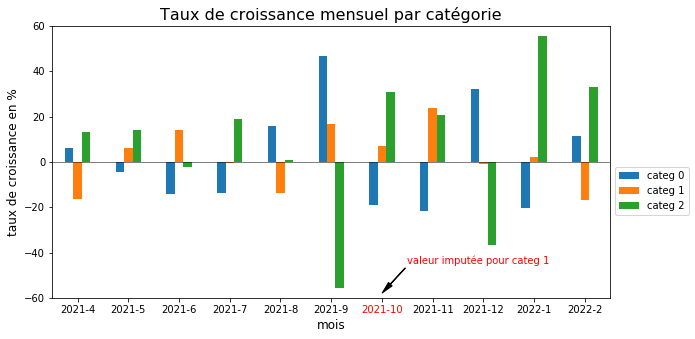

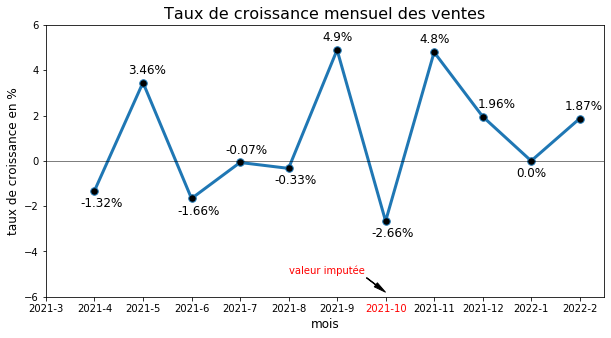

Taux de croissance mensuel moyen:  1.0 %


In [645]:
#Taux de croissance mensuels

#taux mensuels
data_month['growth_tot'] = round(data_month['sales'].pct_change(), 4) * 100
data_month['growth_categ_0'] = round(data_month['categ 0'].pct_change(), 4) * 100
data_month['growth_categ_1'] = round(data_month['categ 1'].pct_change(), 4) * 100
data_month['growth_categ_2'] = round(data_month['categ 2'].pct_change(), 4) * 100

#calcul taux de croissance moyen et imputation de la valeur manquante des ventes categ 1 sur octobre en se basant
#sur le taux de croissance mensuel moyen des ventes de cette categorie sur la periode

#calcul croissance imputée octobre pour cat 1
average_growth_cat_1 = (213120.64 / 186974.17)**(1/12) - 1
cat1_oct_corrige = round(186974.17 * ((1 + average_growth_cat_1)**8))

data_month['categ 1 corrige'] = data_month['categ 1']
data_month.loc[data_month['month'] == 10, 'categ 1 corrige'] = cat1_oct_corrige

data_month['growth_categ_1 corrige'] = round(data_month['categ 1 corrige'].pct_change(), 4) * 100

#calcul croissance total imputée en oct
data_month['sales corrige'] = data_month['sales']
data_month.loc[data_month['month'] == 10, 'sales corrige'] = (data_month.loc[data_month['month'] == 10, 'categ 0'] +
                                                              data_month.loc[data_month['month'] == 10, 'categ 1 corrige'] +
                                                              data_month.loc[data_month['month'] == 10, 'categ 2'])

data_month['growth_tot corrige'] = round(data_month['sales corrige'].pct_change(), 4) * 100

#affichage hist croissance par categ    
data_month_growth = data_month[['growth_categ_0', 'growth_categ_1 corrige', 'growth_categ_2']][1:]

data_month_growth.plot(kind='bar', stacked=False, figsize=(10, 5))
labels = data_month['date'][1:].values
plt.xticks(range(0,len(data_month['date'][1:])), labels, rotation='horizontal')
plt.gca().get_xticklabels()[6].set_color("red")
plt.ylim(-60,60)
plt.xlabel('mois', size = 12)
plt.ylabel('taux de croissance en %', size = 12)
plt.annotate('valeur imputée pour categ 1', xy=(6, -58), xytext=(6.5, -45),arrowprops=dict(
    facecolor='black', shrink=0.01, width = 0.5, headwidth = 5), color = 'red')
plt.legend(['categ 0','categ 1','categ 2'],loc='upper left', frameon=True, bbox_to_anchor=(1, 0.5))
plt.axhline(color = '0', linewidth = 0.5)
plt.title('Taux de croissance mensuel par catégorie', size = 16)
plt.savefig('P4_02_graphiques/hist_taux_croissance_mensuelle_par_categ.png')
plt.show()

#affichage graph croissance totale    
data_month[['date','growth_tot corrige']][1:].plot(kind='line', figsize=(10, 5), marker = '.',
                                                   markerfacecolor='0', markersize = 15, linewidth = 3, legend = False)
labels = data_month['date'].values
plt.xticks(range(0,len(data_month['date'])), labels, rotation='horizontal')
plt.gca().get_xticklabels()[7].set_color("red")
plt.ylim(-6, 6)
plt.xlabel('mois', size = 12)
plt.ylabel('taux de croissance en %', size = 12)
plt.annotate('valeur imputée', xy=(7, -5.8), xytext=(5, -5),arrowprops=dict(
    facecolor='black', shrink=0.01, width = 0.5, headwidth = 5), color = 'red')
plt.axhline(color = '0', linewidth = 0.5)

for i, v in enumerate(data_month['growth_tot corrige'][1:]): #affichage valeurs à coté des points
    if i == 9:
        plt.text(i + 0.7, (round(v,2) - 0.7), str(round(v,3)) + '%', size = 12)
    elif i == 8:
        plt.text(i + 0.9, (round(v,2) + 0.4), str(round(v,3)) + '%', size = 12)   
    else:
        plt.text(i + 0.7, (round(v,2) - 0.7) if v<-0.1 else (round(v, 2) + 0.4), str(round(v,3)) + '%', size = 12)
        
plt.title('Taux de croissance mensuel des ventes', size = 16)
plt.savefig('P4_02_graphiques/graph_taux_croissance_mensuelle.png')
plt.show()

average_growth_tot = (532740.88 / 479312.03)**(1/12) - 1
average_growth_tot
print('Taux de croissance mensuel moyen: ', round(average_growth_tot,2) * 100, '%')

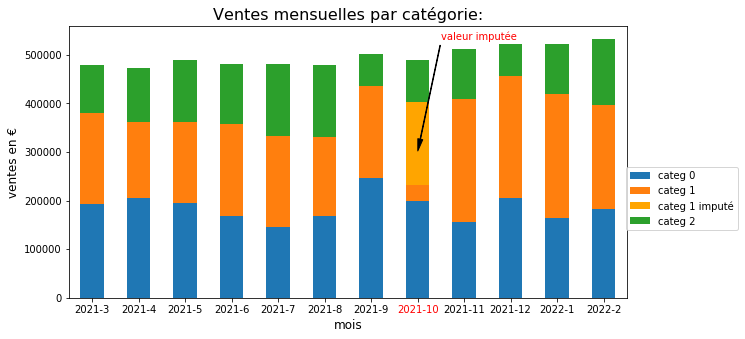

In [646]:
#Affichage croissance mensuelle AVEC valeur imputée octobre
data_month['categ 1 imputé'] = 0
data_month.loc[data_month['month'] == 10, 'categ 1 imputé'] = data_month.loc[data_month['month'] == 10, 'categ 1 corrige'] - data_month.loc[data_month['month'] == 10, 'categ 1']

data_month[['categ 0','categ 1', 'categ 1 imputé','categ 2']].plot(kind='bar', stacked=True, color = ['C0','C1', 'orange', 'C2'], figsize=(10, 5))
plt.xticks(range(0,len(data_month['date'])), labels, rotation='horizontal')
plt.xlabel('mois', size = 12)
plt.ylabel('ventes en €', size = 12)
plt.legend(loc='upper left', frameon=True, bbox_to_anchor=(0.99, 0.5))
plt.title('Ventes mensuelles par catégorie:', size = 16)

plt.gca().get_xticklabels()[7].set_color("red")
plt.annotate('valeur imputée', xy=(7, 300000), xytext=(7.5, 530000),arrowprops=dict(
    facecolor='black', shrink=0.01, width = 0.5, headwidth = 5), color = 'red')

plt.savefig('P4_02_graphiques/hist_ventes_mensuelles_avec_valeurs_imputees.png')
plt.show()

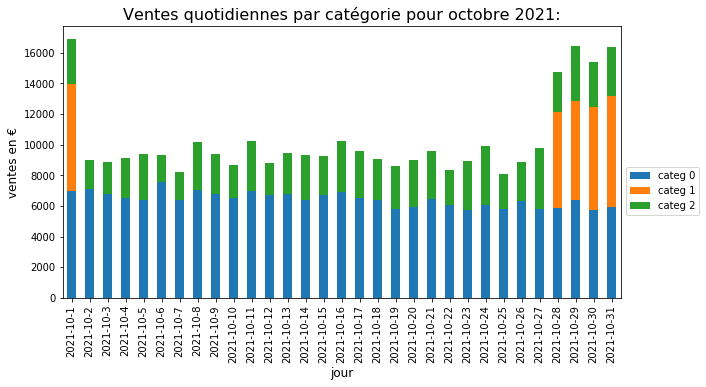

In [647]:
#focus sur les ventes en octobre 2021

#création d'un df regroupant les ventes par jour 
data_day = data.groupby(['year','month','day']).sum()
data_day['sales'] = data_day['price']
data_day = data_day[['sales']]
data_day.reset_index(inplace = True)
data_day['date'] = data_day.year.astype(str) + '-' + data_day.month.astype(str) + '-' + data_day.day.astype(str)

#ajout ventes quotidiennes par categories
for c in categs:
    df_categ = data[data['categ'] == c]
    df_categ = df_categ.groupby(['year','month','day']).sum()
    df_categ.reset_index(inplace = True)
    df_categ['date'] = df_categ.year.astype(str) + '-' + df_categ.month.astype(str) + '-' + df_categ.day.astype(str)
    df_categ['categ ' + str(c)] = df_categ['price']
    del df_categ['price']
    df_categ = df_categ[['date', 'categ ' + str(c)]]
    data_day = data_day.merge(df_categ, how = 'left') 
    data_day.fillna(0, inplace = True)
    
#restriction à octobre 2021
df_2021_10 = data_day[(data_day['year'] == 2021) & (data_day['month'] == 10)]
    
# affichage stacked bar    
df_2021_10[['categ 0','categ 1','categ 2']].plot(kind='bar', stacked=True, figsize=(10, 5))
labels = df_2021_10['date'].values
plt.xticks(range(0,len(df_2021_10['date'])), labels, rotation = 'vertical')
plt.xlabel('jour', size = 12)
plt.ylabel('ventes en €', size = 12)
plt.legend(loc='upper left', frameon=True, bbox_to_anchor=(1, 0.5))
plt.title('Ventes quotidiennes par catégorie pour octobre 2021:', size = 16)
plt.savefig('P4_02_graphiques/hist_ventes_oct2021.png')
plt.show()

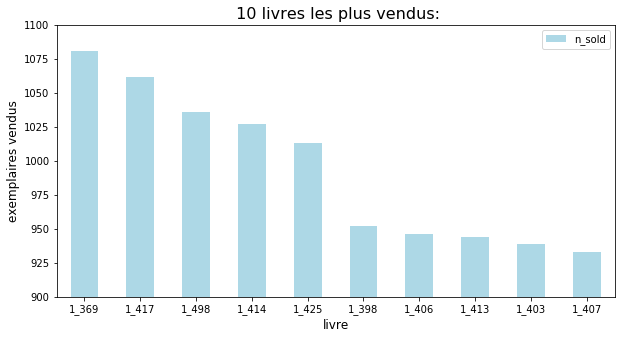

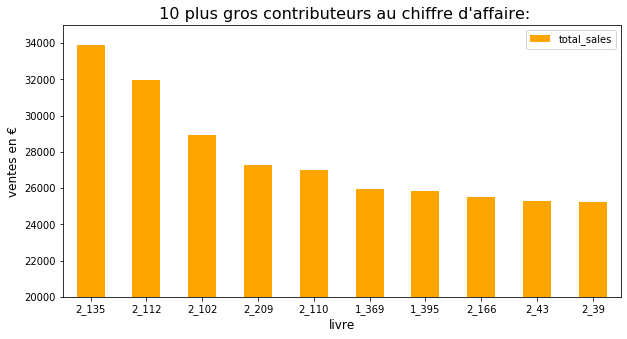

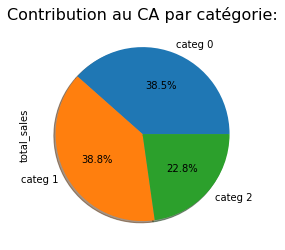

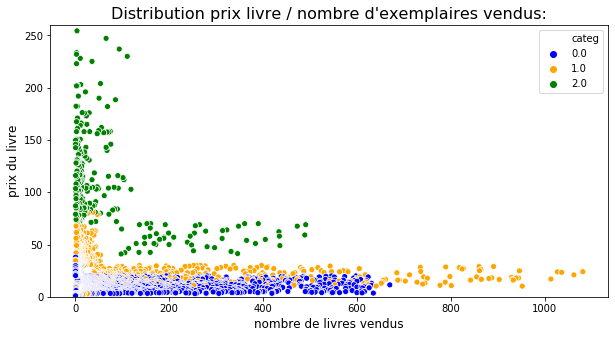


Rapport de corrélation (eta^2) entre lae prix du livre et le nombre d'exemplaires vendus:
0.45853545655830263


In [648]:
#APPROCHE PRODUIT

#on crée un df rassemblant les ventes par livres
livres_count =data['id_prod'].value_counts()
df_livres = pd.DataFrame(livres_count, index = livres_count.index)
df_livres = df_livres.reset_index()
df_livres.columns = ['id_prod','n_sold']

df_livres = df_livres.merge(data[['id_prod', 'price','categ']], on = 'id_prod')
df_livres = df_livres.drop_duplicates()
df_livres.reset_index(inplace = True)
del df_livres['index']
df_livres['total_sales'] = df_livres['n_sold'] * df_livres['price']

#10 livres les plus vendus
df_livres_top_10 = df_livres[['id_prod','n_sold']].head(10)

df_livres_top_10.plot(kind='bar',color = 'lightblue', figsize=(10, 5))

labels = df_livres_top_10['id_prod'].values
n = range(0,len(df_livres_top_10))
plt.xticks(n, labels = labels , rotation='horizontal')
plt.ylim(900,1100)
plt.xlabel('livre', size = 12)
plt.ylabel('exemplaires vendus', size = 12)
plt.title(' 10 livres les plus vendus:', size = 16)
plt.savefig('P4_02_graphiques/hist_top10_bestsellers.png')
plt.show()

#10 plus gros contributeurs
df_livres = df_livres.sort_values(by = 'total_sales', ascending = False)
df_livres_top_10_sales = df_livres[['id_prod','total_sales']].head(10)

df_livres_top_10_sales.plot(kind='bar',color = 'orange', figsize=(10, 5))
labels = df_livres_top_10_sales['id_prod'].values
n = range(0,len(df_livres_top_10))
plt.xticks(n, labels = labels, rotation='horizontal')
plt.ylim(20000,35000)
plt.xlabel('livre', size = 12)
plt.ylabel('ventes en €', size = 12)
plt.title(' 10 plus gros contributeurs au chiffre d\'affaire:', size = 16)
plt.savefig('P4_02_graphiques/hist_top10_livres_CA.png')
plt.show()

#repartion par categ
sales_by_categ = df_livres[['categ','total_sales']].groupby('categ').sum()
sales_by_categ.plot(kind='pie', y = 'total_sales', autopct='%1.1f%%', shadow=True,
                    legend = None, labels = ['categ 0', 'categ 1', 'categ 2'])
plt.title('Contribution au CA par catégorie:', size = 16)
plt.savefig('P4_02_graphiques/pie_contrib_ca_par_categ.png')
plt.show()

# graph par point : price vs n_sold
plt.figure(figsize = (10,5))
colors = {0 : 'b', 1 : 'orange', 2 : 'green'}
c=df_livres['categ'].apply(lambda x: colors[x])
sns.scatterplot(df_livres['n_sold'],df_livres['price'], hue = df_livres['categ'], palette = ['b', 'orange', 'green'])
plt.ylim(0,260)
plt.xlabel('nombre de livres vendus', size = 12)
plt.ylabel('prix du livre', size = 12)
plt.title('Distribution prix livre / nombre d\'exemplaires vendus:', size = 16)
plt.savefig('P4_02_graphiques/hist_prixlivre_vs_nvendus.png')
plt.show()

# rapport de corrélation entre price et n_sold
print('\nRapport de corrélation (eta^2) entre lae prix du livre et le nombre d\'exemplaires vendus:')
print(eta_squared(df_livres['price'], df_livres['n_sold']))

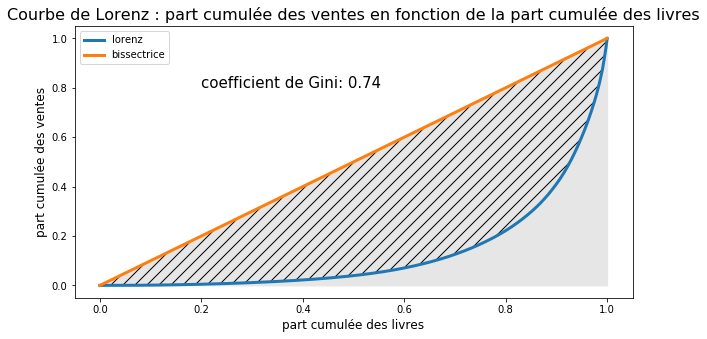

In [649]:
#concentration des ventes
df_livres.sort_values(by = 'total_sales', ascending = True, inplace = True) 
df_livres['cum_sales'] = df_livres['total_sales'].cumsum()

#Courbe de Lorenz
values = df_livres['total_sales'].values
n = len(df_livres)
lorenz = df_livres['cum_sales'] / values.sum()
lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0

plt.figure(figsize=[10,5])
xaxis = np.linspace(0-1/n,1+1/n,n+1) #Il y a un segment de taille n pour chaque individu, plus 1 segment supplémentaire d'ordonnée 0. Le premier segment commence à 0-1/n, et le dernier termine à 1+1/n.
plt.plot(xaxis,lorenz,linewidth = 3)
plt.xlabel('part cumulée des livres', size = 12)
plt.ylabel('part cumulée des ventes', size = 12)
plt.title('Courbe de Lorenz : part cumulée des ventes en fonction de la part cumulée des livres', size = 16)

#Coeff GINI
AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n # Surface sous la courbe de Lorenz. 
S = 0.5 - AUC # surface entre la première bissectrice et la courbe de Lorenz
gini = round(2*S,2)
plt.text(x = 0.2, y = 0.8, s = 'coefficient de Gini: ' + str(gini), fontsize=15)

plt.plot(xaxis,xaxis,linewidth = 3) #bissectrice
plt.fill_between(xaxis,xaxis, color='0.9', edgecolor="0")
plt.fill_between(xaxis, lorenz, xaxis, facecolor="none", hatch="//", edgecolor="0", linewidth=0)
plt.legend(['lorenz','bissectrice'])
plt.savefig('P4_02_graphiques/lorenz_livres.png')
plt.show()

In [650]:
#APPROCHE CLIENTS
df_clients = data.copy()
df_clients = df_clients.set_index(['client_id', 'session_id'])
df_clients.sort_values(by = ['client_id','session_id','date_transaction','time'],inplace = True)

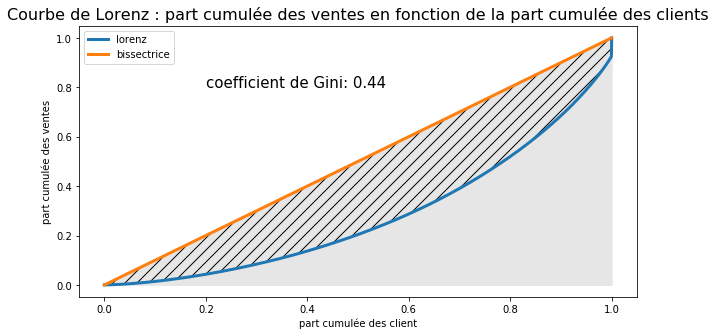

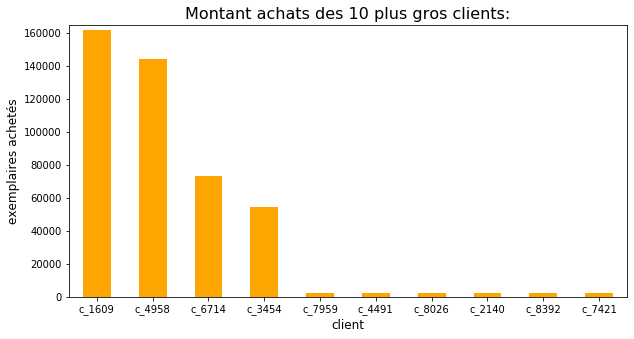

In [651]:
#montant total par client
df_clients_gb_montant = df_clients[['price']].groupby(['client_id', 'session_id']).sum()
df_clients_gb_montant_tot = round(df_clients_gb_montant.groupby(['client_id']).sum(),2)
df_clients_gb_montant_tot.columns =['amount_bought']

#on ajoute l'age des clients au df
df_clients_gb_montant_tot = df_clients_gb_montant_tot.reset_index().merge(df_clients.reset_index()[['client_id',
                                                                                                    'age','age_range', 'age_range_2','sex']])
df_clients_gb_montant_tot.drop_duplicates(inplace = True)

#concentration clients
df_clients_gb_montant_tot.sort_values(by = 'amount_bought', ascending = True, inplace = True) 
df_clients_gb_montant_tot['cum_bought'] = df_clients_gb_montant_tot['amount_bought'].cumsum()

#Courbe de Lorenz
values = df_clients_gb_montant_tot['amount_bought'].values
n_clients = len(df_clients_gb_montant_tot)
lorenz = df_clients_gb_montant_tot['cum_bought'] / values.sum()
lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0

plt.figure(figsize=[10,5])
xaxis = np.linspace(0-1/n_clients,1+1/n_clients,n_clients+1) #Il y a un segment de taille n pour chaque individu, plus 1 segment supplémentaire d'ordonnée 0. Le premier segment commence à 0-1/n, et le dernier termine à 1+1/n.
plt.plot(xaxis,lorenz,linewidth = 3)
plt.xlabel('part cumulée des client')
plt.ylabel('part cumulée des ventes')
plt.title('Courbe de Lorenz : part cumulée des ventes en fonction de la part cumulée des clients', size = 16)

#Coeff GINI
AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n_clients # Surface sous la courbe de Lorenz. 
S = 0.5 - AUC # surface entre la première bissectrice et la courbe de Lorenz
gini = round(2*S,2)
plt.text(x = 0.2, y = 0.8, s = 'coefficient de Gini: ' + str(gini), fontsize=15)

plt.plot(xaxis,xaxis,linewidth = 3) #bissectrice
plt.fill_between(xaxis,xaxis, color='0.9', edgecolor="0")
plt.fill_between(xaxis, lorenz, xaxis, facecolor="none", hatch="//", edgecolor="0", linewidth=0)
plt.legend(['lorenz','bissectrice'])
plt.savefig('P4_02_graphiques/lorenz_clients.png')
plt.show()

#10 plus gros clients
df_clients_gb_montant_tot_10 = df_clients_gb_montant_tot.sort_values(by = 'amount_bought', ascending = False)
df_clients_gb_montant_tot_10 = df_clients_gb_montant_tot_10[['client_id','amount_bought']].head(10)

df_clients_gb_montant_tot_10.plot(kind='bar',color = 'orange', figsize=(10, 5), legend = None)
labels = df_clients_gb_montant_tot_10['client_id'].values
n = range(0,len(df_clients_gb_montant_tot_10))
plt.xticks(n, labels = labels, rotation='horizontal')
plt.ylim(0,165000)
plt.xlabel('client', size = 12)
plt.ylabel('exemplaires achetés', size = 12)

plt.title('Montant achats des 10 plus gros clients:', size = 16)
plt.savefig('P4_02_graphiques/hist_top10clients.png')
plt.show()

In [652]:
#on choisit de supprimer ces 4 clients gros clients outliers
#(probablement pas des particuliers) qui risquent de biaiser les études de corrélations.

df_clients_test = data.copy() #TEST
df_clients_test = df_clients_test.set_index(['client_id', 'session_id'])
df_clients_test.sort_values(by = ['client_id','session_id','date_transaction','time'],inplace = True)


data = data[~data['client_id'].isin(['c_1609', 'c_4958','c_6714','c_3454'])]
df_clients = data.copy()
df_clients = df_clients.set_index(['client_id', 'session_id'])
df_clients.sort_values(by = ['client_id','session_id','date_transaction','time'],inplace = True)

n_clients -= 4

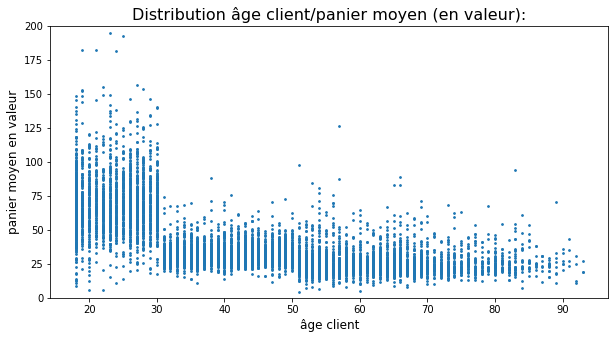

Coefficient de corrélation entre l'âge du client (hors 18 ans) et son panier moyen:
-0.6113835094971033

Rapport de corrélation (eta^2) entre la classe d'age du client et son panier moyen:
0.6357867292719823


In [653]:
#ANALYSE PANIER MOYEN (en valeur)

#panier moyen par client
df_clients_gb_session = df_clients[['price']].groupby(['client_id', 'session_id']).sum()
df_clients_gb_average_bskt = round(df_clients_gb_session.groupby(['client_id']).mean(),2)
df_clients_gb_average_bskt.columns =['average_basket']

#on ajoute l'age des clients
df_clients_gb = df_clients_gb_average_bskt.reset_index().merge(df_clients.reset_index()[['client_id','age','age_range','sex']])
df_clients_gb.drop_duplicates(inplace = True)

# graph par point : panier moyen vs age
plt.figure(figsize = (10,5))
colors = {'m' : 'b', 'f' : 'r'}
plt.scatter(df_clients_gb['age'],df_clients_gb['average_basket'], s = 3)
plt.ylim(0,200)
plt.xlabel('âge client', size = 12)
plt.ylabel('panier moyen en valeur', size = 12)
plt.title('Distribution âge client/panier moyen (en valeur):', size = 16)
plt.show()

# coefficient de corrélation entre age et panier_moyen (on retire les clients qui ont indiqué 18 ans)
X = df_clients_gb[df_clients_gb['age'] != 18]['average_basket']
Y =  df_clients_gb[df_clients_gb['age'] != 18]['age']
print('Coefficient de corrélation entre l\'âge du client (hors 18 ans) et son panier moyen:')
print(st.pearsonr(X, Y)[0])

# rapport de corrélation entre age_range et panier_moyen
print('\nRapport de corrélation (eta^2) entre la classe d\'age du client et son panier moyen:')
print(eta_squared(df_clients_gb['age_range'], df_clients_gb['average_basket']))

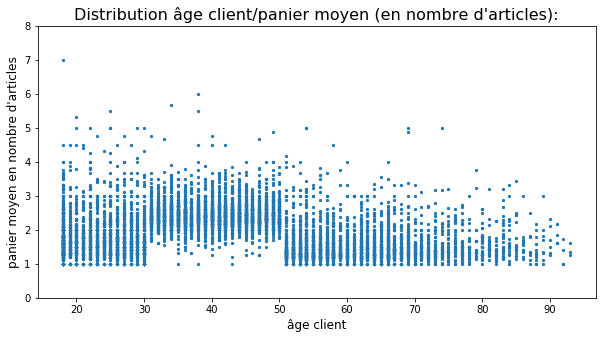

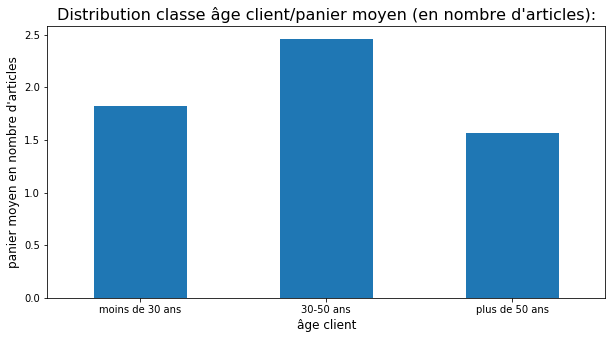

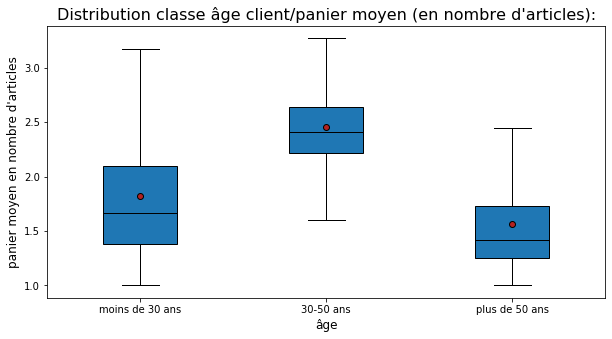

Coefficient de corrélation entre l'âge du client (hors 18 ans) et son panier moyen(en nombre d'articles):
-0.27379270674866946

Rapport de corrélation (eta^2) entre la classe d'age du client et son panier moyen(en nombre d'articles):
0.3754515251458804


In [654]:
#panier moyen en nombre d'articles

#panier moyen par client
df_clients_gb_session_n = df_clients[['price']].groupby(['client_id', 'session_id']).count()
df_clients_gb_average_bskt_n = round(df_clients_gb_session_n.groupby(['client_id']).mean(),2)
df_clients_gb_average_bskt_n.columns =['average_basket']

#on ajoute l'age des clients
df_clients_gb_n = df_clients_gb_average_bskt_n.reset_index().merge(df_clients.reset_index()[['client_id','age','age_range','sex']])
df_clients_gb_n.drop_duplicates(inplace = True)

# graph par point : panier moyen vs age
plt.figure(figsize = (10,5))
colors = {'m' : 'b', 'f' : 'r'}
plt.scatter(df_clients_gb_n['age'],df_clients_gb_n['average_basket'], s = 5)
plt.ylim(0,8)
plt.xlabel('âge client', size = 12)
plt.ylabel('panier moyen en nombre d\'articles', size = 12)
plt.title('Distribution âge client/panier moyen (en nombre d\'articles):', size = 16)
plt.savefig('P4_02_graphiques/scat_paniermoyen_nbre_vs_age.png')
plt.show()

# histogramme :nombre livres achetés vs age_range
df_clients_gb_n[['age_range', 'average_basket']].groupby('age_range').mean().plot(kind='bar', figsize=(10, 5), legend = None)
plt.xticks(rotation='horizontal')
plt.xlabel('âge client', size = 12)
plt.ylabel('panier moyen en nombre d\'articles', size = 12)
plt.title('Distribution classe âge client/panier moyen (en nombre d\'articles):', size = 16)
plt.savefig('P4_02_graphiques/hist_panier moyen_vs_trancheage.png')
plt.show()

# boxplot : panier moyen vs age_range
tranches = ['moins de 30 ans', '30-50 ans', 'plus de 50 ans']
groupes_clients = []
for t in tranches:
    groupes_clients.append(df_clients_gb_n[df_clients_gb_n['age_range']== t]['average_basket'])
medianprops = {'color':"black"} 
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
plt.figure(figsize=(10, 5))
plt.boxplot(groupes_clients, labels=['moins de 30 ans', '30-50 ans', 'plus de 50 ans'], showfliers=False, medianprops=medianprops, 
            vert=True, patch_artist=True, showmeans=True, meanprops=meanprops, widths = 0.4)

plt.title('Distribution classe âge client/panier moyen (en nombre d\'articles):', size = 16)
plt.xlabel('âge', size = 12)
plt.ylabel('panier moyen en nombre d\'articles', size = 12)
plt.savefig('P4_02_graphiques/boxplot_age_vs_paniermoyen.png')
plt.show()

# coefficient de corrélation entre age et panier_moyen (on retire les clients qui ont indiqué 18 ans)
X = df_clients_gb_n[df_clients_gb_n['age'] != 18]['average_basket']
Y =  df_clients_gb_n[df_clients_gb_n['age'] != 18]['age']
print('Coefficient de corrélation entre l\'âge du client (hors 18 ans) et son panier moyen(en nombre d\'articles):')
print(st.pearsonr(X, Y)[0])

# rapport de corrélation entre age_range et panier_moyen
print('\nRapport de corrélation (eta^2) entre la classe d\'age du client et son panier moyen(en nombre d\'articles):')
print(eta_squared(df_clients_gb_n['age_range'], df_clients_gb_n['average_basket']))

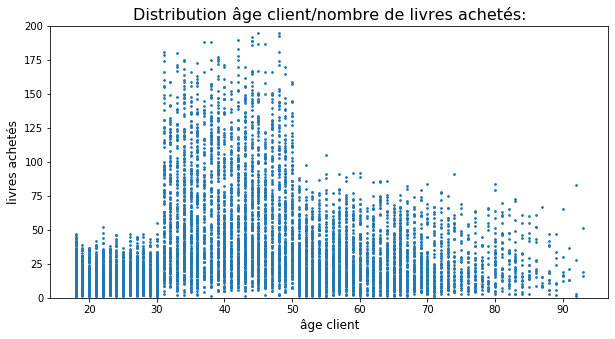

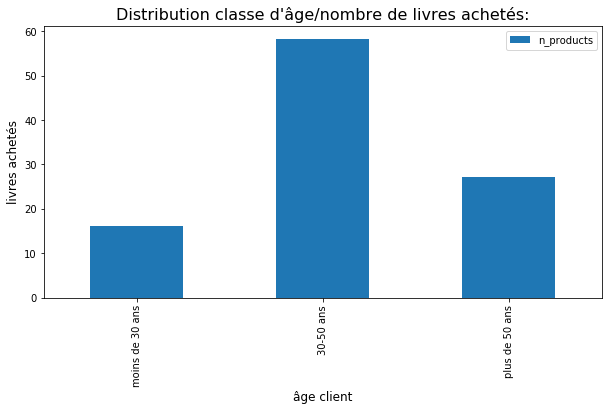

Coefficient de corrélation entre l'âge du client (hors 18 ans) et le nombre total de livres achetés:
-0.019214285614725955

Rapport de corrélation (eta^2) entre la classe d'age du client et le nombre total de livres achetés:
0.290575633782328


In [655]:
#age vs nombre de livres achetés

#nombre de livres achetés par client
df_clients_gb_achats_n = df_clients[['price']].groupby(['client_id', 'session_id']).count()
df_clients_gb_achats_tot = round(df_clients_gb_achats_n.groupby(['client_id']).sum(),2)
df_clients_gb_achats_tot.columns =['n_products']

#on ajoute l'age des clients
df_clients_gb_achats_tot = df_clients_gb_achats_tot.reset_index().merge(df_clients.reset_index()[['client_id','age','age_range', 'age_range_2','sex']])
df_clients_gb_achats_tot.drop_duplicates(inplace = True)

# graph par point :nombre livres achetés vs age
plt.figure(figsize = (10,5))
plt.scatter(df_clients_gb_achats_tot['age'],df_clients_gb_achats_tot['n_products'], s = 3)
plt.ylim(0,200)
plt.xlabel('âge client', size = 12)
plt.ylabel('livres achetés', size = 12)
plt.title('Distribution âge client/nombre de livres achetés:', size = 16)
plt.savefig('P4_02_graphiques/scat_nbreachats_vs_age.png')
plt.show()

# histogramme :nombre livres achetés vs age_range
df_clients_gb_achats_tot[['age_range', 'n_products']].groupby('age_range').mean().plot(kind='bar', figsize=(10, 5))
plt.xlabel('âge client', size = 12)
plt.ylabel('livres achetés', size = 12)
plt.title('Distribution classe d\'âge/nombre de livres achetés:', size = 16)
plt.savefig('P4_02_graphiques/hist_nbreachats_vs_trancheage.png')
plt.show()

# coefficient de corrélation entre age et nombre livres achetés (on retire les clients qui ont indiqué 18 ans)
X = df_clients_gb_achats_tot[df_clients_gb_achats_tot['age'] != 18]['n_products']
Y =  df_clients_gb_achats_tot[df_clients_gb_achats_tot['age'] != 18]['age']
print('Coefficient de corrélation entre l\'âge du client (hors 18 ans) et le nombre total de livres achetés:')
print(st.pearsonr(X, Y)[0])

# rapport de corrélation entre age_range et nbre livres achetés
print('\nRapport de corrélation (eta^2) entre la classe d\'age du client et le nombre total de livres achetés:')
print(eta_squared(df_clients_gb_achats_tot['age_range'], df_clients_gb_achats_tot['n_products']))

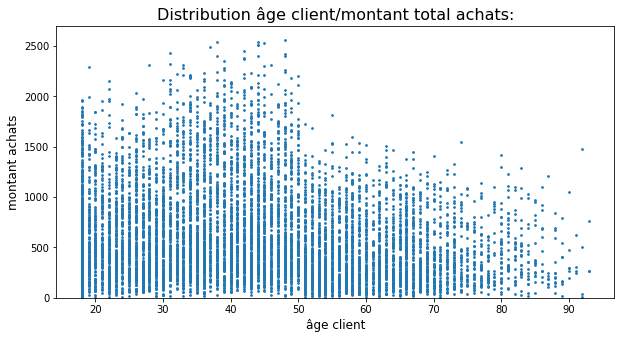

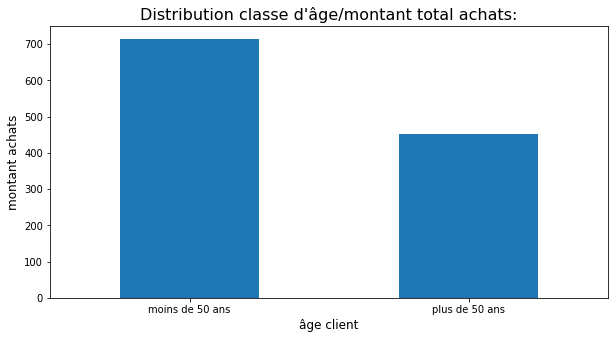

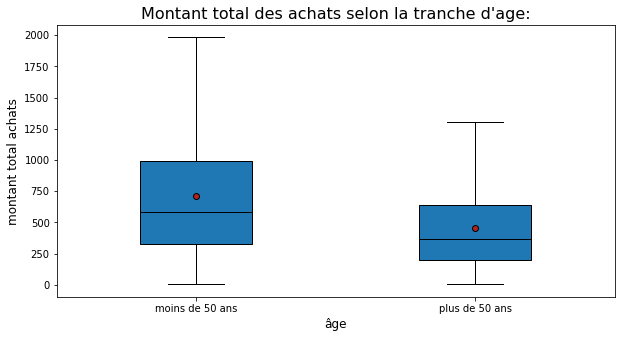

Coefficient de corrélation entre l'âge du client (hors 18 ans) et le montant total acheté:
(-0.19839352807164895, 3.3192231740378463e-73)

Rapport de corrélation (eta^2) entre la classe d'age du client et le montant total acheté:
0.07422212258751054


In [656]:
#age vs montant total achats

df_clients_gb_montant_tot = df_clients_gb_montant_tot[~df_clients_gb_montant_tot['client_id'].isin(['c_1609', 'c_4958','c_6714','c_3454'])]

# graph par point :montant achats vs age
plt.figure(figsize = (10,5))
plt.scatter(df_clients_gb_montant_tot['age'],df_clients_gb_montant_tot['amount_bought'], s = 3)
plt.ylim(0,2700)
plt.xlabel('âge client', size = 12)
plt.ylabel('montant achats', size = 12)
plt.title('Distribution âge client/montant total achats:', size = 16)
plt.savefig('P4_02_graphiques/scat_montantachats_vs_trancheage.png')
plt.show()

# histogramme :montant achats vs age_range
df_clients_gb_montant_tot[['age_range_2', 'amount_bought']].groupby('age_range_2').mean().plot(kind='bar', figsize=(10, 5), legend = None)
plt.xlabel('âge client', size = 12)
plt.xticks(rotation = 'horizontal')
plt.ylabel('montant achats', size = 12)
plt.title('Distribution classe d\'âge/montant total achats:', size = 16)
plt.savefig('P4_02_graphiques/hist_montantachats_vs_age.png')
plt.show()

# boxplot :montant achats vs age_range
tranches = ['moins de 50 ans', 'plus de 50 ans']
groupes_clients = []
for t in tranches:
    groupes_clients.append(df_clients_gb_montant_tot[df_clients_gb_montant_tot['age_range_2']== t]['amount_bought'])
medianprops = {'color':"black"} 
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
plt.figure(figsize=(10, 5))
plt.boxplot(groupes_clients, labels=['moins de 50 ans', 'plus de 50 ans'], showfliers=False, medianprops=medianprops, 
            vert=True, patch_artist=True, showmeans=True, meanprops=meanprops, widths = 0.4)

plt.title('Montant total des achats selon la tranche d\'age:', size = 16)
plt.xlabel('âge', size = 12)
plt.ylabel('montant total achats', size = 12)
plt.savefig('P4_02_graphiques/boxplot_age_vs_montantachats.png')
plt.show()


# coefficient de corrélation entre age et montant achats(on retire les clients qui ont indiqué 18 ans)
X = df_clients_gb_montant_tot[df_clients_gb_montant_tot['age'] != 18]['amount_bought']
Y =  df_clients_gb_montant_tot[df_clients_gb_montant_tot['age'] != 18]['age']
print('Coefficient de corrélation entre l\'âge du client (hors 18 ans) et le montant total acheté:')
print(st.pearsonr(X, Y)[:2])

# rapport de corrélation entre age_range et nbre livres achetés
print('\nRapport de corrélation (eta^2) entre la classe d\'age du client et le montant total acheté:')
print(eta_squared(df_clients_gb_montant_tot['age_range_2'], df_clients_gb_montant_tot['amount_bought']))

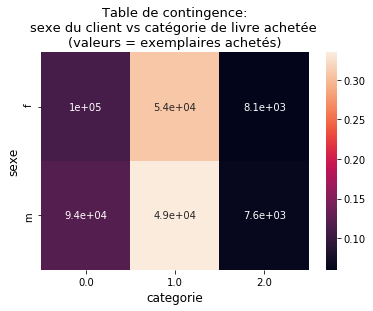

1 : statistique Chi-2 et p-value:
(10.202417277273174, 0.1163825475602433)


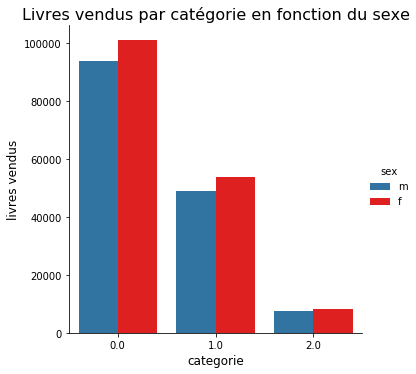

In [657]:
#sexe clients vs categ produit achetés + age clients vs categ produits achetés

#table de contingence
df_clients_2 = df_clients[['categ','sex','age','age_range']].copy()
cont1 = df_clients_2[['sex','categ']].pivot_table(index='sex',columns='categ',aggfunc=len,margins=True,margins_name="Total")
cont = cont1
tx = cont1.loc[:,["Total"]]
ty = cont1.loc[["Total"],:]
n = len(df_clients_2)
indep = tx.dot(ty) / n

measure = (cont1-indep)**2/indep
xi_n = measure.sum().sum()
table = measure/xi_n
sns.heatmap(table.iloc[:-1,:-1],annot=cont1.iloc[:-1,:-1])
plt.title('Table de contingence:\nsexe du client vs catégorie de livre achetée \n(valeurs = exemplaires achetés)', size = 13)
plt.xlabel('categorie', size = 12)
plt.ylabel('sexe', size = 12)
plt.savefig('P4_02_graphiques/cont_sexe_vs_categ.png')
plt.show()
print('1 : statistique Chi-2 et p-value:')
print(st.chi2_contingency(cont1)[:2])

#histogramme
sns.catplot(x ='categ', data = df_clients_2, hue="sex", kind="count", palette = ['C0','r'])
plt.title('Livres vendus par catégorie en fonction du sexe', size = 16)
plt.xlabel('categorie', size = 12)
plt.ylabel('livres vendus', size = 12)
plt.savefig('P4_02_graphiques/hist_sex_vs_categ.png')
plt.show()

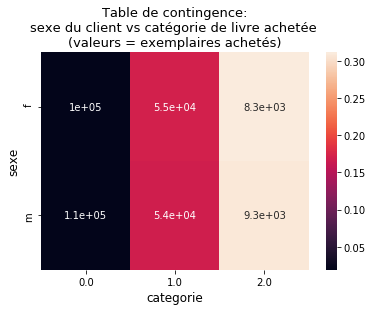

1 : statistique Chi-2 et p-value:
(81.86933350990711, 1.467788236006804e-15)


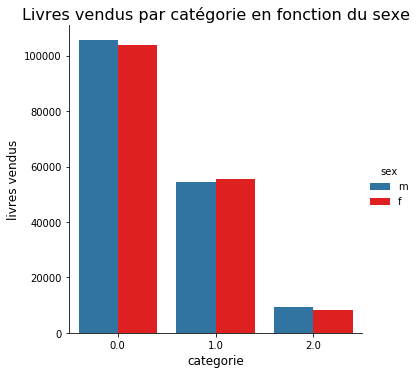

In [660]:
#TEST SEX VS CAT EN PRENANT EN COMPTE LES 4 GROS CLIENTS

#table de contingence
df_clients_2 = df_clients_test[['categ','sex','age','age_range']].copy()
cont1 = df_clients_2[['sex','categ']].pivot_table(index='sex',columns='categ',aggfunc=len,margins=True,margins_name="Total")
cont = cont1
tx = cont1.loc[:,["Total"]]
ty = cont1.loc[["Total"],:]
n = len(df_clients_2)
indep = tx.dot(ty) / n

measure = (cont1-indep)**2/indep
xi_n = measure.sum().sum()
table = measure/xi_n
sns.heatmap(table.iloc[:-1,:-1],annot=cont1.iloc[:-1,:-1])
plt.title('Table de contingence:\nsexe du client vs catégorie de livre achetée \n(valeurs = exemplaires achetés)', size = 13)
plt.xlabel('categorie', size = 12)
plt.ylabel('sexe', size = 12)
plt.savefig('P4_02_graphiques/cont_sexe_vs_categ.png')
plt.show()
print('1 : statistique Chi-2 et p-value:')
print(st.chi2_contingency(cont1)[:2])

#histogramme
sns.catplot(x ='categ', data = df_clients_2, hue="sex", kind="count", palette = ['C0','r'])
plt.title('Livres vendus par catégorie en fonction du sexe', size = 16)
plt.xlabel('categorie', size = 12)
plt.ylabel('livres vendus', size = 12)
plt.savefig('P4_02_graphiques/hist_sex_vs_categ.png')
plt.show()

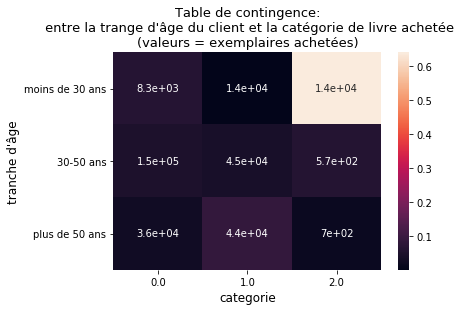

statistique Chi-2 et p-value:
(137099.41052060697, 0.0)


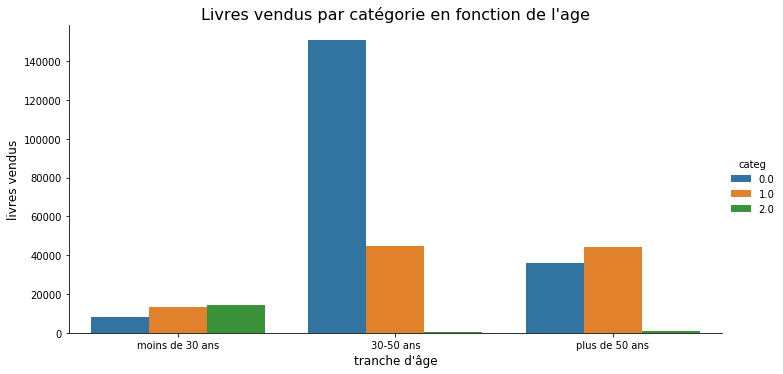

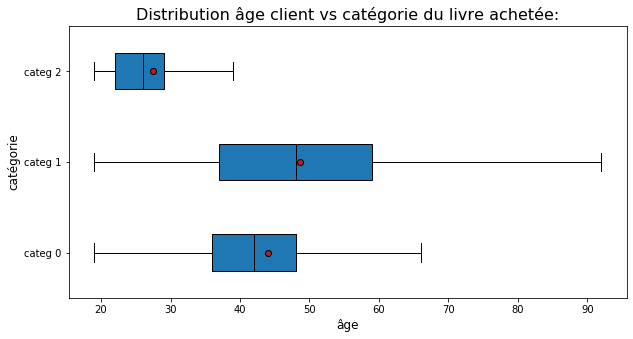


Rapport de corrélation (eta^2) entre l'age du client (hors 18 ans) et la catégorie de livre achetée:
0.11281696159853859

Rapport de corrélation (eta^2) entre l'age du client (hors 18 ans) et la catégorie de livre achetée:
0.09944329645467687


In [565]:
#age clients vs categ produits achetés

#table de contingence
cont2 = df_clients_2[['age_range','categ']].pivot_table(index='age_range',columns='categ',aggfunc=len,margins=True,margins_name="Total")

tx = cont2.loc[:,["Total"]]
ty = cont2.loc[["Total"],:]
n = len(df_clients_2)
indep = tx.dot(ty) / n
measure = (cont2-indep)**2/indep
xi_n = measure.sum().sum()
table = measure/xi_n
sns.heatmap(table.iloc[:-1,:-1],annot=cont2.iloc[:-1,:-1])
plt.xlabel('categorie', size = 12)
plt.ylabel('tranche d\'âge', size = 12)
plt.title('Table de contingence:\n entre la trange d\'âge du client et la catégorie de livre achetée\n(valeurs = exemplaires achetées)', size = 13)
plt.savefig('P4_02_graphiques/cont_categ_vs_trancheage.png')
plt.show()
print('statistique Chi-2 et p-value:')
print(st.chi2_contingency(cont2)[:2])

#histogramme
sns.catplot(x ='age_range', data = df_clients_2, hue="categ", kind="count", height=5, aspect=2)
plt.title('Livres vendus par catégorie en fonction de l\'age', size = 16)
plt.xlabel('tranche d\'âge', size = 12)
plt.ylabel('livres vendus', size = 12)
plt.savefig('P4_02_graphiques/hist_categ_vs_trancheage.png')
plt.show()

# boxplot : age vs categ
categs = [0,1,2]
groupes_clients = []
for c in categs:
    groupes_clients.append(df_clients_2[(df_clients_2['categ'] == c) & (df_clients_2['age'] != 18)]['age'])
medianprops = {'color':"black"} 
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
plt.figure(figsize=(10, 5))
plt.boxplot(groupes_clients, labels=['categ 0', 'categ 1', 'categ 2'], showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops, widths = 0.4)

plt.title('Distribution âge client vs catégorie du livre achetée:', size = 16)
plt.xlabel('âge', size = 12)
plt.ylabel('catégorie', size = 12)
plt.savefig('P4_02_graphiques/boxplot_age_vs_categ.png')
plt.show()

# rapport de corrélation entre age et categ
print('\nRapport de corrélation (eta^2) entre l\'age du client (hors 18 ans) et la catégorie de livre achetée:')
print(eta_squared(df_clients_2['categ'], df_clients_2['age']))
print('\nRapport de corrélation (eta^2) entre l\'age du client (hors 18 ans) et la catégorie de livre achetée:')
print(eta_squared(df_clients_2[df_clients_2['age'] != 18]['categ'], df_clients_2[df_clients_2['age'] != 18]['age']))

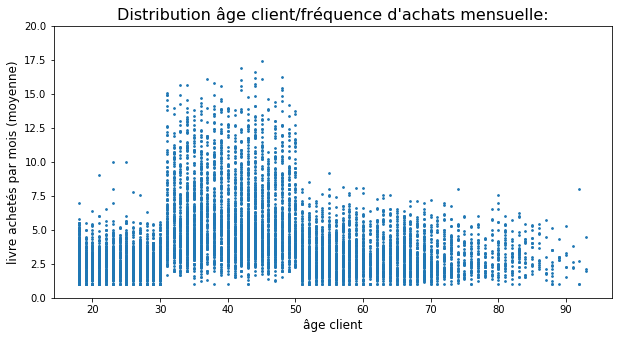

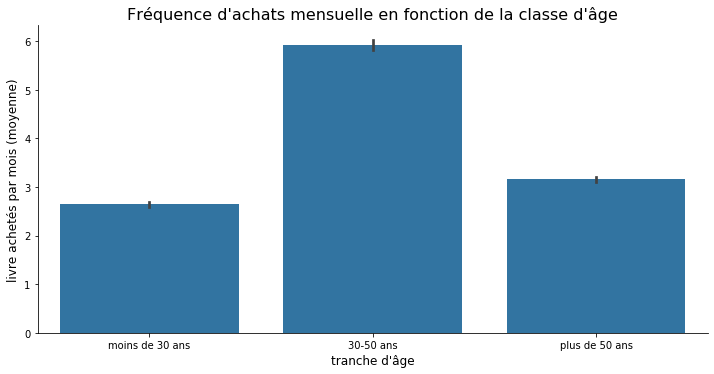

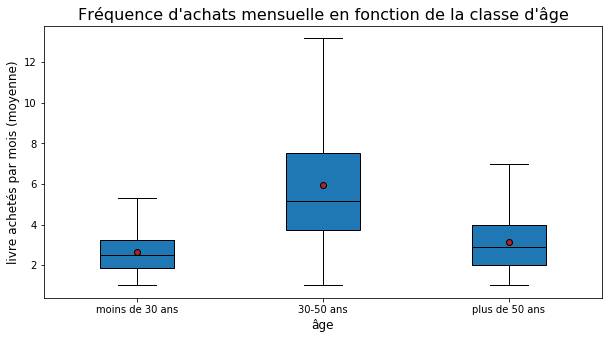

Coefficient de corrélation entre l'âge du client (hors 18 ans) et la fréquence d'achats mensuelle:
-0.07333484616056363

Rapport de corrélation (eta^2) entre la classe d'age du client et la fréquence d'achats mensuelle:
0.3328848547203383


In [566]:
#nombre d'achats par mois / vs sex /vs age

#on retire le mois d'octobre qui comprend des données manquantes qui peuvent biaiser l'analyse

df_monthly = df_clients[df_clients['month'] != 10].reset_index().copy()
df_monthly = df_monthly[['month', 'client_id', 'session_id']]
df_monthly = df_monthly.groupby(['client_id','month']).count()
df_monthly = round(df_monthly.groupby(['client_id']).mean(),2)
df_monthly.rename(columns = {'session_id': 'n__monthly_bought'}, inplace = True)

#on ajoute l'age des clients
df_monthly = df_monthly.reset_index().merge(df_clients.reset_index()[['client_id','age','age_range','sex']])
df_monthly.drop_duplicates(inplace = True)

# graph par point :montant achats vs age
plt.figure(figsize = (10,5))
plt.scatter(df_monthly['age'],df_monthly['n__monthly_bought'], s = 3)
plt.ylim(0,20)
plt.xlabel('âge client', size = 12)
plt.ylabel('livre achetés par mois (moyenne)', size = 12)
plt.title('Distribution âge client/fréquence d\'achats mensuelle:', size = 16)
plt.savefig('P4_02_graphiques/scat_frequenceachat_vs_trancheage.png')
plt.show()

# histogramme :montant achats vs age_range
sns.catplot(x ='age_range', y = 'n__monthly_bought', data = df_monthly, kind= 'bar', height=5, aspect=2, color = 'C0')
plt.title('Fréquence d\'achats mensuelle en fonction de la classe d\'âge', size = 16)
plt.xlabel('tranche d\'âge', size = 12)
plt.ylabel('livre achetés par mois (moyenne)', size = 12)
plt.savefig('P4_02_graphiques/hist_frequenceachat_vs_trancheage.png')
plt.show()

# boxplot : frequence achats vs age_range
tranches = ['moins de 30 ans', '30-50 ans', 'plus de 50 ans']
groupes_clients = []
for t in tranches:
    groupes_clients.append(df_monthly[df_monthly['age_range']== t]['n__monthly_bought'])
medianprops = {'color':"black"} 
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
plt.figure(figsize=(10, 5))
plt.boxplot(groupes_clients, labels=['moins de 30 ans', '30-50 ans', 'plus de 50 ans'], showfliers=False, medianprops=medianprops, 
            vert=True, patch_artist=True, showmeans=True, meanprops=meanprops, widths = 0.4)

plt.title('Fréquence d\'achats mensuelle en fonction de la classe d\'âge', size = 16)
plt.xlabel('âge', size = 12)
plt.ylabel('livre achetés par mois (moyenne)', size = 12)
plt.savefig('P4_02_graphiques/boxplot_age_vs_frequenceachats.png')
plt.show()

# coefficient de corrélation entre age et montant achats(on retire les clients qui ont indiqué 18 ans)
X = df_monthly[df_monthly['age'] != 18]['n__monthly_bought']
Y =  df_monthly[df_monthly['age'] != 18]['age']
print('Coefficient de corrélation entre l\'âge du client (hors 18 ans) et la fréquence d\'achats mensuelle:')
print(st.pearsonr(X, Y)[0])

# rapport de corrélation entre age_range et nbre livres achetés
print('\nRapport de corrélation (eta^2) entre la classe d\'age du client et la fréquence d\'achats mensuelle:')
print(eta_squared(df_monthly['age_range'], df_monthly['n__monthly_bought']))

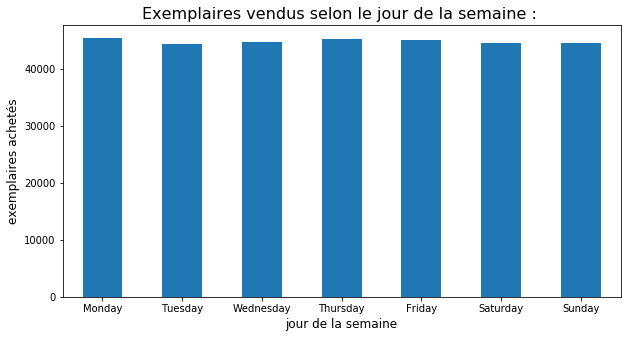

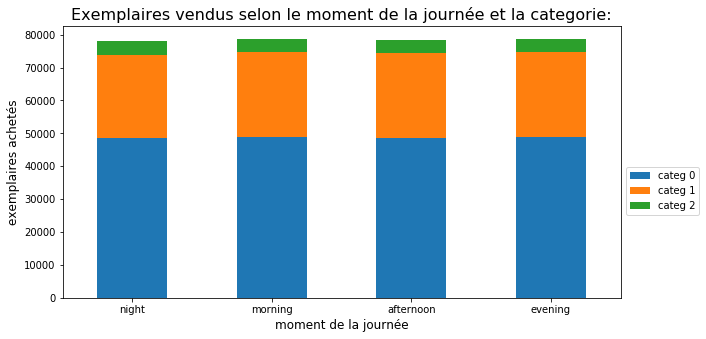

In [567]:
#ventes selon jour de la semaine
data_week_day = data.copy()
data_week_day_gb = data_week_day[['week_day','price']].groupby('week_day').count()
data_week_day_gb = data_week_day_gb.reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'])
data_week_day_gb

#hist
data_week_day_gb.plot(kind='bar', figsize=(10, 5), legend = None)
plt.xticks(rotation='horizontal')
plt.xlabel('jour de la semaine', size = 12)
plt.ylabel('exemplaires achetés', size = 12)
plt.title('Exemplaires vendus selon le jour de la semaine : ', size = 16)
plt.savefig('P4_02_graphiques/hist_nvendus_vs_joursemaine.png')
plt.show()

#ventes en fonction du timeslot et de la categ
data_timeslot = df_clients.copy()
data_timeslot_gb = data_timeslot[['timeslot','price']].groupby('timeslot').count()
data_timeslot_gb = data_timeslot_gb.reindex(['night','morning','afternoon','evening'])
data_timeslot_gb['categ 0'] = data_timeslot[data_timeslot['categ'] == 0][['timeslot','price']].groupby('timeslot').count()
data_timeslot_gb['categ 1'] = data_timeslot[data_timeslot['categ'] == 1][['timeslot','price']].groupby('timeslot').count()
data_timeslot_gb['categ 2'] = data_timeslot[data_timeslot['categ'] == 2][['timeslot','price']].groupby('timeslot').count()
data_timeslot_gb.reset_index(inplace = True)

#affichage stacked bar    
data_timeslot_gb[['categ 0','categ 1','categ 2']].plot(kind='bar', stacked=True, figsize=(10, 5))
labels = data_timeslot_gb['timeslot'].values
plt.xticks(range(0,len(data_timeslot_gb['timeslot'])), labels, rotation='horizontal')
plt.xlabel('moment de la journée', size = 12)
plt.ylabel('exemplaires achetés', size = 12)
plt.legend(loc='upper left', frameon=True, bbox_to_anchor=(1, 0.5))
plt.title('Exemplaires vendus selon le moment de la journée et la categorie:', size = 16)
plt.savefig('P4_02_graphiques/hist_nvendus_vs_timeslot.png')
plt.show()

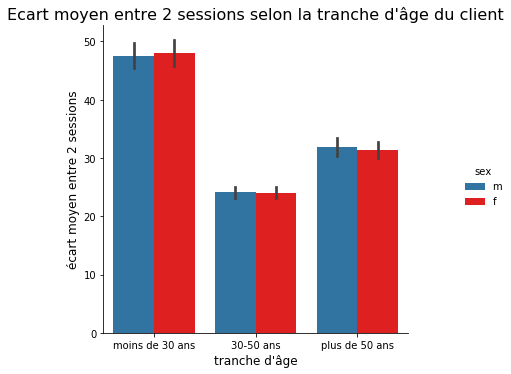

In [568]:
#etude age vs ecart moyen entre sessions

#creation du df contenant l'écart moyen entre les sessions
df_clients_gb_sessions = df_clients[['price']].groupby(['client_id', 'session_id']).sum()
df_clients_gb_sessions = df_clients_gb_sessions.reset_index().merge(df_clients.reset_index()[['session_id','date_transaction']])
df_clients_gb_sessions.sort_values(by = ['client_id','date_transaction'], inplace = True)
df_clients_gb_sessions.drop_duplicates(inplace = True)
df_clients_gb_sessions.drop(columns = ['price'], inplace = True)
df_clients_gb_sessions['previous'] = df_clients_gb_sessions['date_transaction'].shift(1)
df_clients_gb_sessions['since_last_session'] = df_clients_gb_sessions['date_transaction'] - df_clients_gb_sessions['previous'] #colonne contenant le nombre de jours depuis la derniere session
df_clients_gb_sessions.drop(index = [0], columns = ['date_transaction', 'previous'], inplace = True)
df_clients_gb_sessions['since_last_session'] = df_clients_gb_sessions['since_last_session'].astype('timedelta64[D]')
df_clients_gb_sessions = round(df_clients_gb_sessions[df_clients_gb_sessions['since_last_session'] > 0].groupby(['client_id']).mean(),2) #on supprime les premieres lignes de chaque client (qui sont négatives)

#ajout de la colonne age et sex
df_clients_gb_sessions = df_clients_gb_sessions.reset_index().merge(df_clients.reset_index()[['client_id','age','age_range','sex']])
df_clients_gb_sessions.drop_duplicates(inplace = True)

#histo
sns.catplot(x ='age_range', y = 'since_last_session', data = df_clients_gb_sessions, kind = 'bar', hue="sex", palette = ['C0','r'])
plt.title('Ecart moyen entre 2 sessions selon la tranche d\'âge du client', size = 16)
plt.xlabel('tranche d\'âge', size = 12)
plt.ylabel('écart moyen entre 2 sessions', size = 12)
plt.savefig('P4_02_graphiques/hist_ecartsessions_vs_trancheage.png')
plt.show()

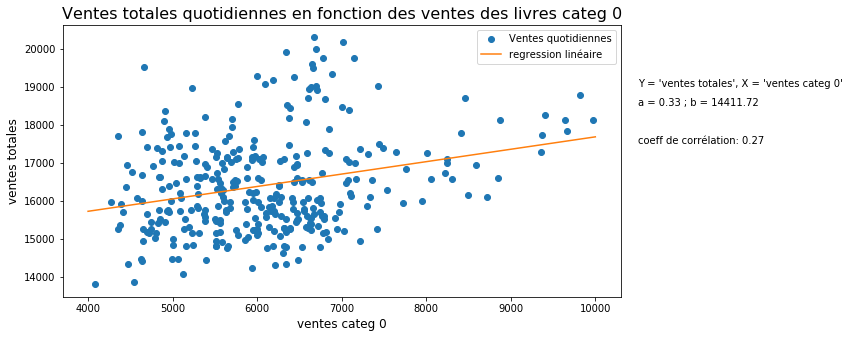

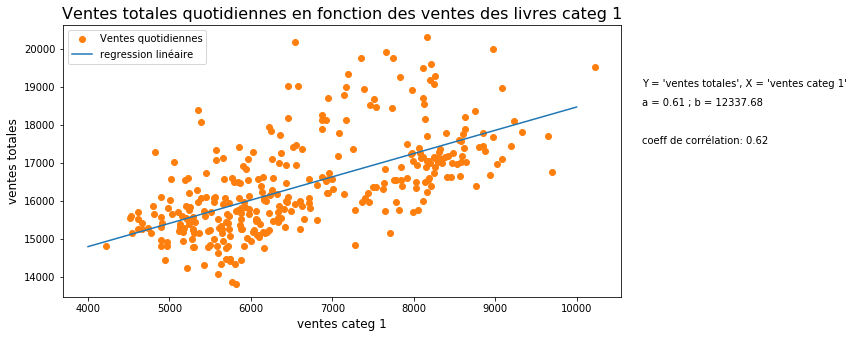

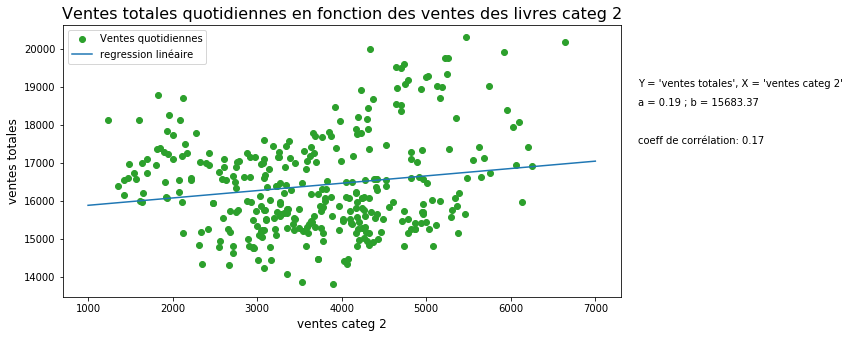

In [569]:
#correlation ventes mensuelles totales vs ventes mensuelles d'une catégorie
data_day_sans_oct = data_day[data_day['month'] != 10]

#categ 0
plt.figure(figsize = (10,5))
Y = data_day_sans_oct['sales']
X = data_day_sans_oct[['categ 0']]
X = X.copy() # On modifiera X, on en crée donc une copie
X['intercept'] = 1.
result = sm.OLS(Y, X).fit() # OLS = Ordinary Least Square (Moindres Carrés Ordinaire)
a,b = result.params['categ 0'],result.params['intercept']
#Affichage droite
plt.plot( data_day_sans_oct[['categ 0']], data_day_sans_oct['sales'], "o")
plt.plot(np.linspace(4000,10000,10),[a*x+b for x in np.linspace(4000,10000,10)])
plt.title('Ventes totales quotidiennes en fonction des ventes des livres categ 0', size = 16)
plt.legend(['Ventes quotidiennes', 'regression linéaire'])
plt.xlabel('ventes categ 0', size = 12)
plt.ylabel('ventes totales', size = 12)
plt.text(s = 'Y = \'ventes totales\', X = \'ventes categ 0\'', x = 10500, y = 19000)
plt.text(s = f'a = {round(a, 2)} ; b = {round(b, 2)}', x = 10500, y = 18500)
c = round(st.pearsonr(data_day_sans_oct['categ 0'], Y)[0], 2)
plt.text(s = f'coeff de corrélation: {c}', x = 10500, y = 17500)
plt.savefig('P4_02_graphiques/scat_ventestotales_vs_ventescateg0.png')
plt.show()

#categ 1
plt.figure(figsize = (10,5))
Y = data_day_sans_oct['sales']
X = data_day_sans_oct[['categ 1']]
X = X.copy() # On modifiera X, on en crée donc une copie
X['intercept'] = 1.
result = sm.OLS(Y, X).fit() # OLS = Ordinary Least Square (Moindres Carrés Ordinaire)
a,b = result.params['categ 1'],result.params['intercept']
#Affichage droite
plt.plot( data_day_sans_oct[['categ 1']], data_day_sans_oct['sales'], "o", color = 'C1')
plt.plot(np.linspace(4000,10000,10),[a*x+b for x in np.linspace(4000,10000,10)])
plt.title('Ventes totales quotidiennes en fonction des ventes des livres categ 1', size = 16)
plt.legend(['Ventes quotidiennes', 'regression linéaire'])
plt.xlabel('ventes categ 1', size = 12)
plt.ylabel('ventes totales', size = 12)
plt.text(s = 'Y = \'ventes totales\', X = \'ventes categ 1\'', x = 10800, y = 19000)
plt.text(s = f'a = {round(a, 2)} ; b = {round(b, 2)}', x = 10800, y = 18500)
c = round(st.pearsonr(data_day_sans_oct['categ 1'], Y)[0], 2)
plt.text(s = f'coeff de corrélation: {c}', x = 10800, y = 17500)
plt.savefig('P4_02_graphiques/scat_ventestotales_vs_ventescateg1.png')
plt.show()

#categ 2
plt.figure(figsize = (10,5))
Y = data_day_sans_oct['sales']
X = data_day_sans_oct[['categ 2']]
X = X.copy() # On modifiera X, on en crée donc une copie
X['intercept'] = 1.
result = sm.OLS(Y, X).fit() # OLS = Ordinary Least Square (Moindres Carrés Ordinaire)
a,b = result.params['categ 2'],result.params['intercept']
#Affichage droite
plt.plot( data_day_sans_oct[['categ 2']], data_day_sans_oct['sales'], "o", color = 'C2')
plt.plot(np.linspace(1000,7000,10),[a*x+b for x in np.linspace(1000,7000,10)])
plt.title('Ventes totales quotidiennes en fonction des ventes des livres categ 2', size = 16)
plt.legend(['Ventes quotidiennes', 'regression linéaire'])
plt.xlabel('ventes categ 2', size = 12)
plt.ylabel('ventes totales', size = 12)
plt.text(s = 'Y = \'ventes totales\', X = \'ventes categ 2\'', x = 7500, y = 19000)
plt.text(s = f'a = {round(a, 2)} ; b = {round(b, 2)}', x = 7500, y = 18500)
c = round(st.pearsonr(data_day_sans_oct['categ 2'], Y)[0], 2)
plt.text(s = f'coeff de corrélation: {c}', x = 7500, y = 17500)
plt.savefig('P4_02_graphiques/scat_ventestotales_vs_ventescateg2.png')
plt.show()